# Finite-Volume Physics-Informed Neural Networks for Compressible Flow
Physics-informed neural networks (PINNs) is an efficient numerical tool which provides solutions to partial differential equations (PDEs), despite the fact that, theoretically, it exhibits limited capability in solving problems with only continuous solutions. Typical PINNs utilize automatic differentiation to differentiate the neural network with respect to the governing PDE. However, automatic differentiation cannot resolve, consistently, discontinuities that arise in solutions to hyperbolic conservation laws, specifically, the compressible Euler equations. Automatic differentiation (AD) symbolically calculates the analytic derivative at a give coordinate value. To minimize the reliance on automatic differentiation, we introduce a hybrid finite volume (FVM) and PINNs technique, which we coin, FV-PINNs. FV-PINNs combines the high-order accuracy of FVM schemes such as WENO5 with RK-3 time integration, with the generalizability of a PINN. Once a FV-PINN is trained, the neural network provides an implicit solution (implicit neural representation), or rather, a parameterization of the approximate solution to the PDE. This allows for reevaluating the solution on subsets of the original training spatial-temporal domain,, regardless of how irregular, and obtain solutions in seconds.  Moreover, FV-PINNs allow for concrete error and stability analysis from standard FVM, and a simplistic construction of the deep neural network (DNN), by minimizing tedious hyperparameter tuning. This notebook focuses on combining an underlying FVM scheme with PINNs. However, the methodology presented can be generalized to other numerical methods such as the finite difference method (FDM) and the finite element methods (FEM). 

 This jupyter notebook is designed to demonstrated the capabilities of Finite-Voume Physics-Informed Neural Networks (FV-PINNs) ability to simulate, numerically, compressible flow. In this example, we will be solving the 1-D compressible Euler equations, with the initial state of the Sod shocktube problem (Sod, 1978). FV-PINNs are able to simuate 2-D and 3-D compressible flow with discontinuous initial states. The notebooks for higher-dimensional flow are in still in development, however, for the time being, the author thought it would be beneficial to demostrate FV-PINNs on a simpler problem.

Consider the compressible Euler Equations in 1-D,

\begin{equation} \frac{\partial \boldsymbol{U}}{\partial t} + \frac{\partial \boldsymbol{F}}{\partial x} = \boldsymbol{0}, \ \  (x,t)\in \Omega \times (0,T] 
\end{equation}


where, $T > 0$, $\Omega \equiv (0,1)$ and
\begin{equation*} \boldsymbol{U} = \begin{bmatrix}
    \rho \\
    \rho u \\
    E
    \end{bmatrix}, \ \   \boldsymbol{F}= \begin{bmatrix}
    \rho u \\
    \rho u^2 + p \\
    \left(E + p\right)u
    \end{bmatrix}, 
\end{equation*}
The initial state for the Sod problem is as follows:
\begin{equation*}  U_0 = (\rho_0, u_0, p_0) = 
\begin{cases}
(1.0, 0.0, 1.0), \ x \leq 0.5\\
(0.125, 0.0, 0.1), \ x > 0.5\\
\end{cases}
\end{equation*}

In [1]:
# Import libraries
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from DeepFlow import *

In [2]:
# Seeds
torch.manual_seed(123456)
np.random.seed(123456)
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Generate Neural Network
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  # Define neural network
        self.net.add_module('Linear_layer_1', nn.Linear(1, 30))                     # First linear layer
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              # First activation Layer

        for num in range(2, 7):                                                     # Number of layers (2 through 7)
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       # Linear layer
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 # Activation Layer
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))                 # Output Layer

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_FVM(self, x,q,nx):
        y = self.net(x)
        q_1 = torch.tensor(q[0,1:nx-1].flatten()[:, None],dtype=torch.float32).to(device)
        q_2 = torch.tensor(q[1,1:nx-1].flatten()[:, None], dtype=torch.float32).to(device)
        q_3 = torch.tensor(q[2,1:nx-1].flatten()[:, None], dtype=torch.float32).to(device)
        f = (((y[:,0:1] - q_1))**2).mean() + (((y[:,1:2] - q_2))**2).mean() + (((y[:,2:] - q_3))**2).mean()
        return f

In [4]:
# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

For a particular cell, $i$, we take the volume integral over the total volume of the cell, $v_i$, which gives:
\begin{equation}
    \int_{v_i} \frac{\partial \boldsymbol{U}}{\partial t} \ dv+  \int_{v_i} \nabla \cdot  \boldsymbol{f}(\boldsymbol{U}) \ dv = \boldsymbol{0}, \ \ \boldsymbol{f} = \left( \boldsymbol{F}, \boldsymbol{G} \right), \ \nabla = \left( \frac{\partial }{\partial x}, \frac{\partial }{\partial y}\right) \ \ \ \ \ \ \ \ \ \ (2)
\end{equation}
Integrating the first term to get the volume average and applying the divergence theorem to the second yields
\begin{equation*}
    v_i \frac{d \bar{\boldsymbol{U}}}{d t} + \oint_{S_i} \boldsymbol{f}(\boldsymbol{U}) \cdot d \boldsymbol{n}\ d{S} = \boldsymbol{0}
\end{equation*}
where $S_i$ represents the total surface area of the cell and $\boldsymbol{n}$ is a unit vector normal to the surface and pointing outward. Therefore, the generalize} finite-volume formulation is as follows:
\begin{equation*}
  \frac{d \bar{\boldsymbol{U}}}{d t} + \frac{1}{v_i}\oint_{S_i} \boldsymbol{f}(\boldsymbol{U}) \cdot d \boldsymbol{n}\ d{S} = \boldsymbol{0}   
\end{equation*}

In CFD, researchers are constantly designing new numerical schemes to solve (2). Deciding which numerical scheme can be a difficult pursuit, especially when it comes to solve problems with shock-waves, rarefaction fans, and supersonic flow. Although (2) provides a general equation for the FVM method, it does not specify which FVM scheme to use. We will integrate in time using a two-step Runge-Kutta method (RK-2). To numerically solve for the fluxes (the second term in (2)), we utilize the Harten-Lax-van Leer-Einfeldt (or HLLE) flux solver.  Although RK-2 and the HLLE flux solver are second order accurate, the initial conditions for each physical quantity are discontinuous. This is problematic since a PDE and the FVM assume global differentiability. Therefore, without modification to the numerical method, inaccuracies, such as spurious oscillations or immense dissipation typically occur near sharp (discontinuous) regions of the solution. Hence, we modify the flux solver such that it detects sharp gradient changes, and convert the flux solver into a low resolution scheme. In other-words, we reduce the order of accuracy  of the flux-solver in order to capture discontinuities in the solution. Converting the flux solver into a low resolution scheme is referred to as flux-limiting. Therefore, we will use the monotonized central flux limiter to capture discontinuities such as shocks, rarefaction fans, and contact discontinuities. 

For simplicity, we define the HLLE solver in 1-D, as it is easily generalizable to higher dimensions. Hence, $\boldsymbol{f(U)} = \boldsymbol{F}$. We discretize (2) such that $S_i = {x_{j-1/2},x_{j+1/2}}$, and $v_i = \Delta x$ is the spatial step. Hence, we have that
\begin{equation}
    \frac{\partial \bar{\boldsymbol{U}}}{\partial t} + \frac{1}{\Delta x}\left( \boldsymbol{F}_{j+1/2} - \boldsymbol{F}_{j-1/2}\right)
\end{equation}
where 
$$
    \boldsymbol{F}_{j+1/2} = \boldsymbol{f}(\boldsymbol{U}_{j+1/2})
$$
Define $\boldsymbol{U}_{j+1/2}$ to be:
$$
    \boldsymbol{U}_{j+1/2} = - \frac{\boldsymbol{f}(\boldsymbol{U}_{j+1}) - \boldsymbol{f}(\boldsymbol{U}_{j})}{b^r_{j+1/2} - b^{l}_{j+1/2}} + \frac{b^{r}_{j+1/2}\boldsymbol{U}_{j+1} - b^{l}_{j+1/2}\boldsymbol{U}_{j}}{b^r_{j+1/2} - b^{l}_{j+1/2}}
$$
where $b^{l}<b^{r}$ are the left and right speeds. Next, we define the right centered flux as:

\begin{equation*}
    \boldsymbol{F}_{j+1/2} = \frac{b^{+}_{j+1/2}\boldsymbol{f}(\boldsymbol{U}_{j}) - b^{-}_{j+1/2}\boldsymbol{f}(\boldsymbol{U}_{j+1})}{b^{+}_{j+1/2} - b^{-}_{j+1/2}}
    + \frac{b^{+}_{j+1/2}b^{-}_{j+1/2}}{b^{+}_{j+1/2} - b^{-}_{j+1/2}}
\end{equation*}

where
$$
\begin{split}
    b^{+}_{j+1/2} &= \max(0,b^{r}_{j+1/2}) \\
    b^{-}_{j+1/2} &= \min(0,b^{l}_{j+1/2})
\end{split}
$$
We compute the so-called Roe averages as follows:
$$
\begin{split}
    \bar{u}_{j+1/2} &= \frac{\sqrt{\rho_j}u_j + \sqrt{\rho_{j+1}u_{i+1}}}{\sqrt{\rho_j} + \sqrt{\rho_{j+1}}} \\
    \bar{H}_{j+1/2} &= \frac{\sqrt{\rho_{j}}H_{j} + \sqrt{\rho_{j+1}}H_{j+1}}{\sqrt{\rho_j} + \sqrt{\rho_{j+1}}} \\
    \bar{c}_{j+1/2} &= \sqrt{(\gamma -1) \left(\bar{H}_{j+1/2} - 0.5\bar{u}^2_{j+1/2} \right)}
    \end{split}
$$
where $$
    H_{j}  = \frac{1}{\rho_j}\left( E_{j} + p_{j}\right), \ \ c_{j} = \sqrt{(\gamma -1)\left({H}_{j+1/2} - 0.5{u}^2_{j+1/2} \right) }
$$
Thus, the newly defined speeds are as follows:
$$
 \begin{split}
    b^{l}_{j+1/2} &= \min(\hat{u}_{j+1/2} - \hat{c}_{j+1/2},u_{j} - c_{j}) \\
    b^{r}_{j+1/2} &= \max(\hat{u}_{j+1/2} + \hat{c}_{j+1/2},u_{j+1} - c_{j+1})
\end{split}
$$
Lastly, the monotonized central flux limiter is defined by:
$$
    \phi_{mc}(\boldsymbol{r}) = \max\left[0,\min(2\boldsymbol{r},0.5(1+\boldsymbol{r}),2)\right], \ \ \boldsymbol{r}_j = \frac{\boldsymbol{U}_{j} - \boldsymbol{U}_{j-1}}{\boldsymbol{U}_{j+1} - \boldsymbol{U}_{j}}
$$

In [5]:
def Euler_IC(x, case):
    if case == 1:
        p = [1, 0.1]
        u = [0, 0]
        rho = [1, 0.125]
    if case == 2:
        p = [1, 0.1]
        u = [0.75, 0]
        rho = [1, 0.125]

    r0 = np.zeros(len(x))
    u0 = np.zeros(len(x))
    p0 = np.zeros(len(x))

    x_middle = (x[-1] - x[0]) / 2

    L = np.where(x <= x_middle)
    R = np.where(x >= x_middle)

    r0[L], r0[R] = rho[0], rho[1]
    u0[L], u0[R] = u[0], u[1]
    p0[L], p0[R] = p[0], p[1]

    return r0, u0, p0

FV-PINNs combine the accuracy of tradition finite volume schemes, with the generalizeability of a quintensential PINNs. The FVM with HLLE flux reconstuction and flux limiting, provide highly accurate solutions to compressible CFD problems. Instead of differentiating the neural network with respect to the governing PDE, we discretize the neural network, and minimize the MSE of the neural network evaluated on the respective numerical scheme. 



1. Generate weights $\theta \in \mathbb{R}^k$ and a deep neural network (DNN), $\boldsymbol{\tilde{U}}(x_j,t_n, \theta) =\boldsymbol{\tilde{U}}^{n}_j $, where $(x_j,t_n)$ are inputs to the network, and $\boldsymbol{\tilde{U}}^n_j = [\tilde{\rho}^n_j, \tilde{u}^n_j,\tilde{p}^n_j ] $ are the outputs. The number of layers, neurons per layer, and activation functions for each layer are prescribed by the user. 
 
2. Minimize ||$\tilde{\boldsymbol{U}}^{0} - \boldsymbol{U}_0||^2$ via stochastic gradient descent.
 
3. while ${t<T}$: 
$$
G(\theta) = \bigg|\bigg|      \tilde{\boldsymbol{U}}^{n+1}_j  - \left[\tilde{\boldsymbol{U}}^{n}_j+ \frac{\Delta t}{\Delta x}\left( \tilde{\boldsymbol{F}^n}_{j+1/2} - \tilde{\boldsymbol{F}^n}_{j-1/2}\right) \right]\bigg|\bigg|^2  , \ \ j = 1...,N_x-1 
$$
       
4. Update $\theta$ by performing stochastic gradient descent:
\begin{equation*}
\begin{split}
    \theta = \theta - \eta \nabla_\theta G(\theta) 
    \end{split}
\end{equation*}
where $\eta$ is the learning rate.

5. Employ boundary conditions

6. $t = t + \Delta t$

In [6]:
# Initialization
lr = 0.0005                                                        # Learning rate
nx = 400                                                           # Number of discrete spatial points
cfl = 0.9                                                          # CFL condition for stability
tEnd = 0.15                                                        # Final time
n = 5                                                              # Number of degrees of freedom
IC = 1                                                             # Initial condition
Lx = 1                                                             # Right boundary

gamma = (n + 2) / n                                                # Heat capacity ratio
dx = Lx / nx                                                       # Spatial step
xc = np.arange(dx / 2, Lx, dx)                                     # Spatial grid

r0, u0, p0 = Euler_IC(xc, IC)                                      # Initial Condition
E0 = p0 / ((gamma - 1) * r0) + 0.5 * u0 ** 2                       # Initial total energy
a0 = np.sqrt(gamma * p0 / r0)                                      # Initial wave sqeed

# Initial Conditions
nx += 2                                                            # Ghost points
q0 = np.vstack((r0, r0 * u0, r0 * E0))                             # Hard constrained initial condition
zero = np.vstack((0, 0, 0))
q0 = np.hstack((zero, q0, zero))

# Boundary Conditions
q0[:, [0]] = q0[:, [1]]                   
q0[:, [nx - 1]] = q0[:, [nx - 2]]

#
lambda0 = np.abs(u0) + a0
dt0 = cfl * dx / np.max(lambda0)

q = q0
t = 0
it = 0
dt = dt0
lambdas = lambda0

# Training domain
X = xc.flatten()[:, None]                                          # Vectorized spatial domain
x_int_train = X                                                    # Training domain
x_test = X                                                         # Reevaluation domain
x_int_train = torch.tensor(x_int_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)


# Finite Volume PINNs
while (t < tEnd):
        
        # RK-2 predictor
        DF = autodiff()                                                   # Predictor Flux
        qs = q[:, :] - dt * DF.MUSCL_EULER_1D(q[:, :], gamma, dx, nx, 'HLLE')
        
        # Predictor Boundary Conditions
        qs[:, [0]] = qs[:, [1]]
        qs[:, [nx - 1]] = qs[:, [nx - 2]]
        
        # RK-2 corrector
        DF_new = autodiff()                                               # Corrector Flux
        qnew = (q[:, :] + qs[:, :] - dt *  DF_new.MUSCL_EULER_1D(qs[:, :], gamma, dx, nx, 'HLLE')) / 2
        
        # Corrector Boundary Conditions
        qnew[:, [0]] = qnew[:, [1]]
        qnew[:, [nx - 1]] = qnew[:, [nx - 2]]
        
        # Density, velocity, Energy, pressure, and speed of sounds
        r = qnew[[0], :]                                                      
        u = qnew[[1], :] / r
        E = qnew[[2], :] / r
        p = (gamma - 1) * r * (E - 0.5 * u ** 2)
        a = np.sqrt(gamma * p / r)
        
        lambdas = np.abs(u) + a
        dt = cfl * dx / np.max(lambdas)
        
        # Time step
        if t + dt > tEnd:
            dt = tEnd - t
        t = t + dt
        it = it + 1
        
        print('.....................................')
        print('Time iteration: %d' % it)
        
        # Initialize Neural Network
        model = DNN().to(device)
        # Loss and optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # Train FV-PINNs
        def train(epoch):
            model.train()
            def closure():
                optimizer.zero_grad()
                loss_FVM = model.loss_FVM(x_int_train, qnew, nx)
                loss = loss_FVM
                # Print iteration, loss of PDE and ICs
                #print(f'epoch {epoch} loss_pde:{loss_FVM:.8f}')
                loss.backward()
                return loss

            # Optimize loss function
            loss = optimizer.step(closure)
            loss_value = loss.item() if not isinstance(loss, float) else loss
            # Print total loss
            #print(f'epoch {epoch}: loss {loss_value:.6f}')
            return loss_value
        
        print('Start training t = %f' % t)
        tic = time.time()
        loss_value = np.inf
        epoch = 0
        while loss_value > 0.0000001:
            loss_value = train(epoch)
            epoch += 1
        toc = time.time()
        total_time = toc - tic
        print('Total training time (secs): %f' % total_time)
        
        # Neural network solution
        q_nn = to_numpy(model(x_test))
        q_nn = q_nn.transpose()
        q = np.zeros((3, nx))
        q[:, 1:nx - 1] = q_nn
        
        # BCs
        q[:, [0]] = q[:, [1]]
        q[:, [nx - 1]] = q[:, [nx - 2]]
        

.....................................
Time iteration: 1
Start training t = 0.001202
Total training time (secs): 138.355946
.....................................
Time iteration: 2
Start training t = 0.002352
Total training time (secs): 221.713672
.....................................
Time iteration: 3
Start training t = 0.003492
Total training time (secs): 233.457231
.....................................
Time iteration: 4
Start training t = 0.004621
Total training time (secs): 395.589427
.....................................
Time iteration: 5
Start training t = 0.005729
Total training time (secs): 177.683384
.....................................
Time iteration: 6
Start training t = 0.006831
Total training time (secs): 209.258574
.....................................
Time iteration: 7
Start training t = 0.007924
Total training time (secs): 424.288096
.....................................
Time iteration: 8
Start training t = 0.009003
Total training time (secs): 593.349385
................

In [20]:
# Refined domain evaluation - evaluate parametrized solution on refined grid
nx_test = 500 
dx_test = Lx/(nx_test)
xc_test = np.arange(dx_test/2, Lx, dx_test)                                     # Spatial grid
X_test  = torch.tensor(xc_test.flatten()[:, None], dtype=torch.float32).to(device)

tic = time.time()
q_nn_test = to_numpy(model(X_test))
toc = time.time()
total_time = toc - tic

print('....................................................')
print('Total time on refined grid (secs): %f' % total_time)
print('....................................................')

nx_test +=2
q_nn_test = q_nn_test.transpose()

q_test = np.zeros((3, nx_test))
q_test[:, 1:nx_test - 1] = q_nn_test
q_test[:, [0]] = q_test[:, [1]]
q_test[:, [nx_test - 1]] = q_test[:, [nx_test - 2]]

scipy.io.savemat('Sod_Shock_Tube.mat', {'x': xc_test, 'rho': q_test[0, 1:nx_test-1],
                                            'u': q_test[1, 1:nx_test-1] / q_test[0, 1:nx_test-1],
                                            'E': q_test[2, 1:nx_test-1]/q_test[0, 1:nx_test-1]})

....................................................
Total time on refined grid (secs): 0.006601
....................................................


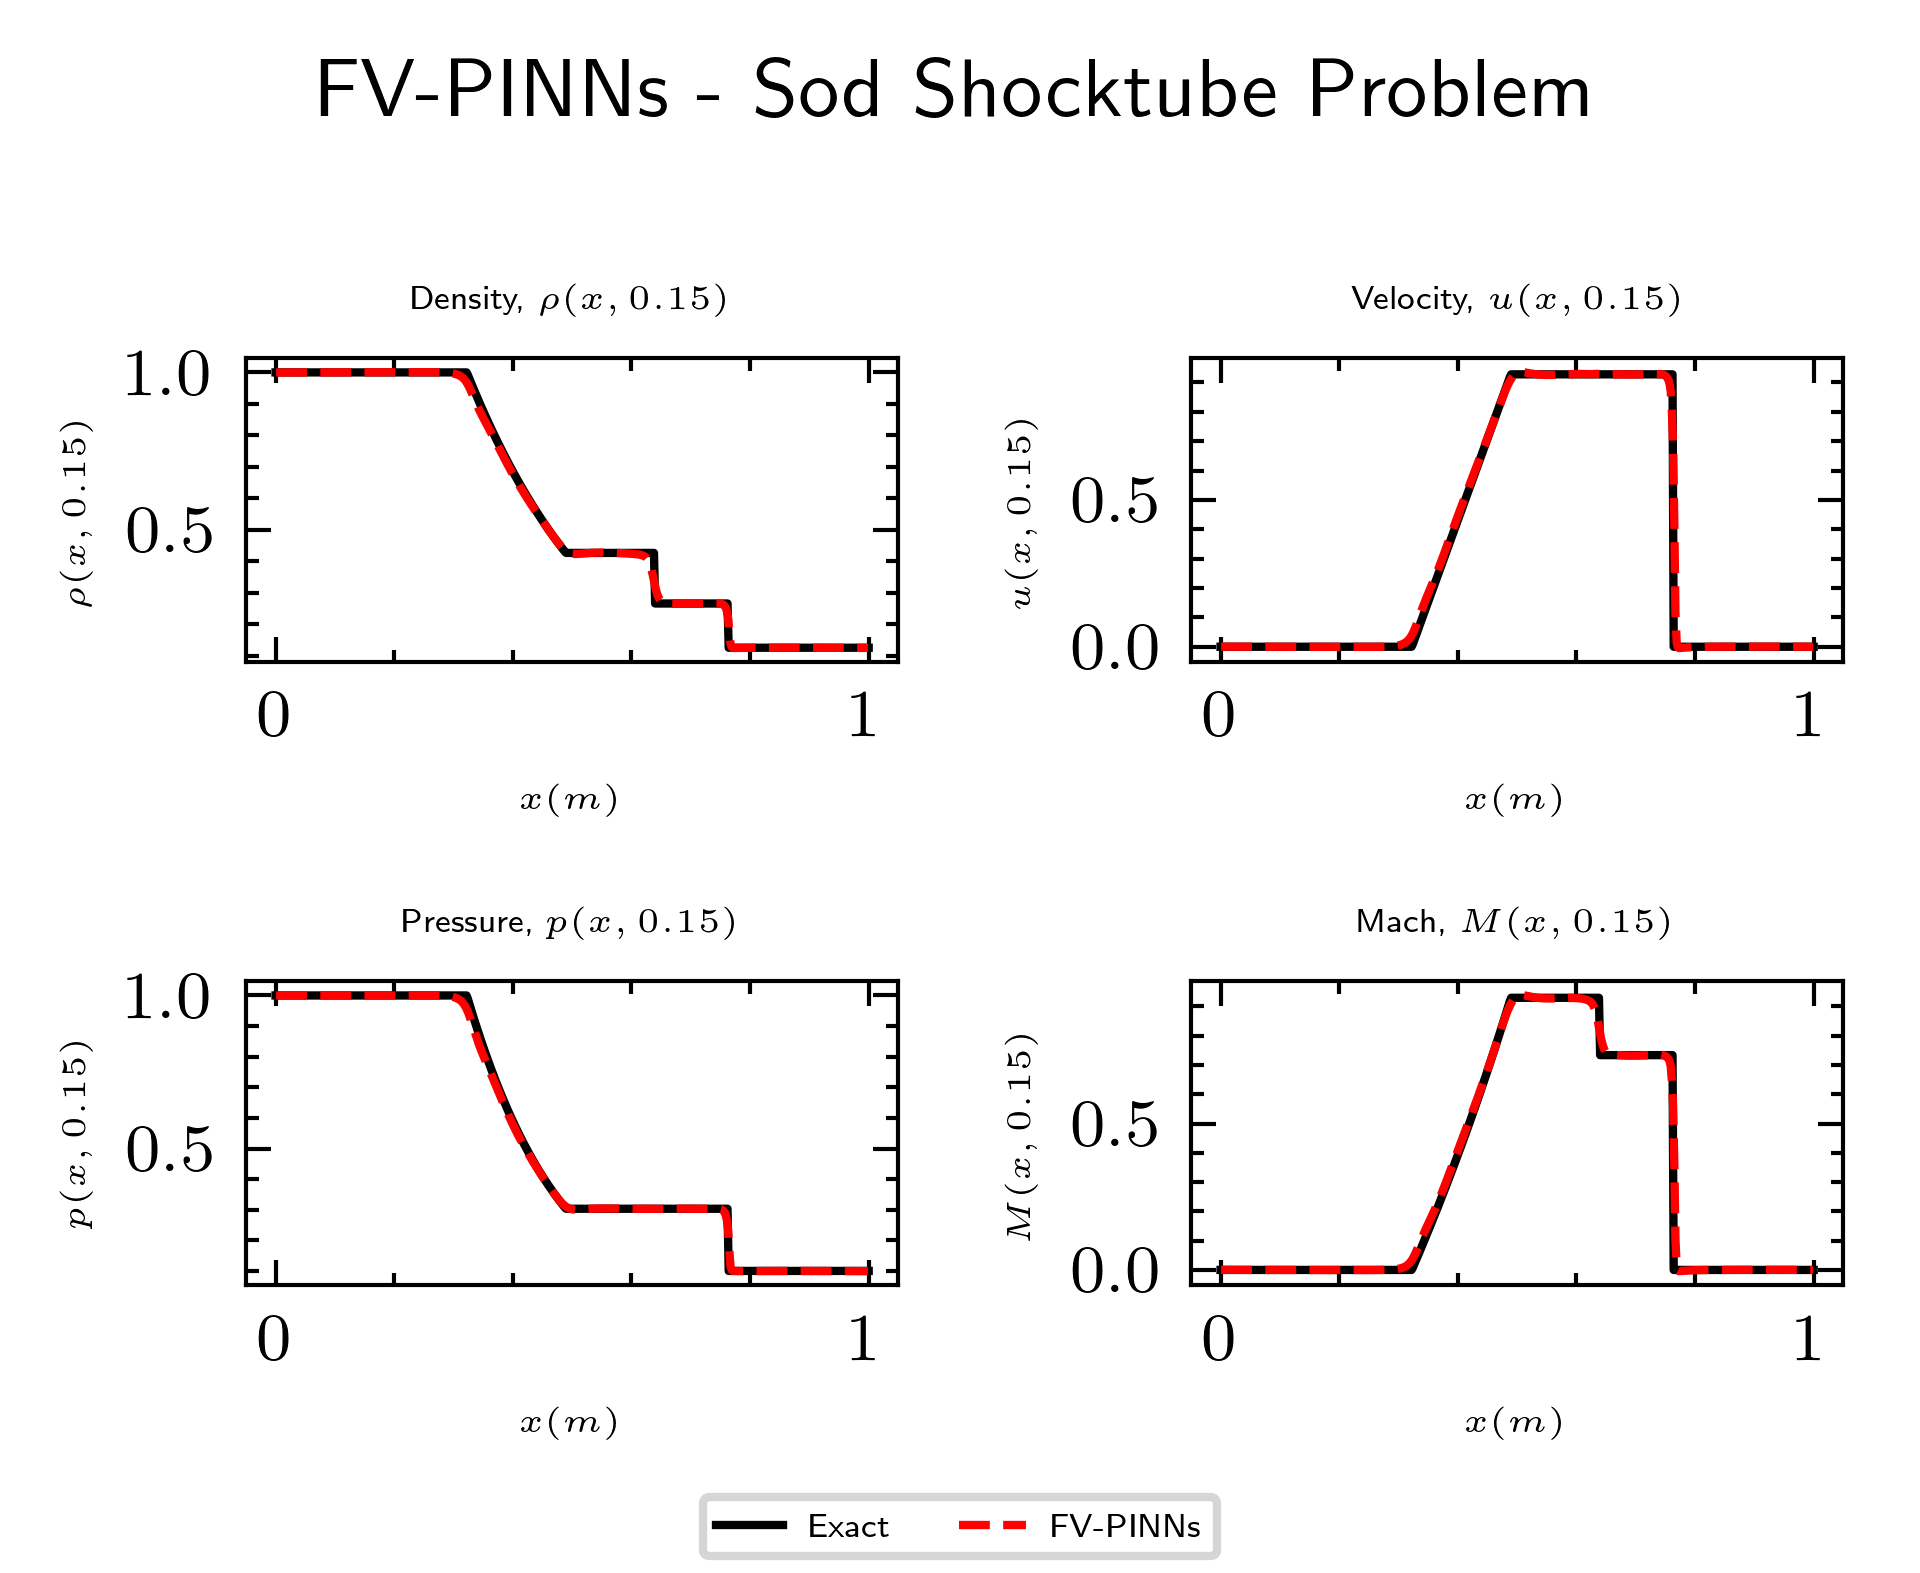

In [23]:
data = scipy.io.loadmat('Sod_Shock_Tube.mat')                                 # Import Solution data

xc   = data['x'].flatten()[:,None]                                            
rho = data['rho'].flatten()[:,None]
u   = data['u'].flatten()[:,None]
e   = data['E'].flatten()[:,None]
E   = data['E'].flatten()[:,None]*rho
pp  = (1.4-1)*rho*(e-0.5*u**2)
M = u/np.sqrt(1.4*pp/rho);

data = scipy.io.loadmat('sod_exact.mat') 
xe = data['xe'].flatten()[:,None]
re = data['re'].flatten()[:,None]
ue   = data['ue'].flatten()[:,None]
Ee  = data['Ee'].flatten()[:,None]
pe  = data['pe'].flatten()[:,None]
Me = ue/np.sqrt(1.4*pe/re);
with plt.style.context(['science','ieee']):
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
    for p in [1]:
        
        ax1.plot(xe, re, label = p)
        ax1.plot(xc, rho,  label = p)
            
        ax2.plot(xe, ue, label = p)
        ax2.plot(xc, u,label = p)
            
            
        ax3.plot(xe, pe, label = p)
        ax3.plot(xc, pp, label = p)
            
        ax4.plot(xe, Me, label = p)
        ax4.plot(xc, M, label = p)
        
        ax1.set_xlabel(r'$x(m)$',fontsize = 4)
        ax1.set_ylabel(r'$\rho(x,0.15)$',fontsize = 4)
        ax1.set_title(r'Density, $\rho(x,0.15)$',fontsize = 4)
        
        ax2.set_xlabel(r'$x(m)$',fontsize = 4)
        ax2.set_ylabel(r'$u(x,0.15)$',fontsize = 4)
        ax2.set_title(r'Velocity, $u(x,0.15)$',fontsize = 4)
        
        ax3.set_xlabel(r'$x(m)$',fontsize = 4)
        ax3.set_ylabel(r'$p(x,0.15)$',fontsize = 4)
        ax3.set_title(r'Pressure, $p(x,0.15)$',fontsize = 4)
        
        ax4.set_xlabel(r'$x(m)$',fontsize = 4)
        ax4.set_ylabel(r'$M(x,0.15)$',fontsize= 4)
        ax4.set_title(r'Mach, $M(x,0.15)$',fontsize = 4)

fig.legend(['Exact', 'FV-PINNs'], ncol = 2, loc='lower center', fontsize= 4)
csfont = {'fontname':'serif'}
plt.suptitle(r'FV-PINNs - Sod Shocktube Problem', fontsize= 10, **csfont)
plt.tight_layout()
plt.show()